# Experimental design and pattern estimation
This week's lab will be about the basics of pattern analysis of (f)MRI data. We assume that you've worked through the two Nilearn tutorials already. 

Functional MRI data are most often stored as 4D data, with 3 spatial dimensions ($X$, $Y$, and $Z$) and 1 temporal dimension ($T$). But most pattern analyses assume that data are formatted in 2D: trials ($N$) by patterns (often a subset of $X$, $Y$, and $Z$). Where did the time dimension ($T$) go? And how do we "extract" the patterns of the $N$ trials? In this lab, we'll take a look at various methods to estimate patterns from fMRI time series. Because these methods often depend on your experimental design (and your research question, of course), the first part of this lab will discuss some experimental design considerations. After this more theoretical part, we'll dive into how to estimate patterns from fMRI data.

**What you'll learn**: At the end of this tutorial, you ...

* Understand the most important experimental design factors for pattern analyses;
* Understand and are able to implement different pattern estimation techniques

**Estimated time needed to complete**: 8-12 hours

In [1]:
# We need to limit the amount of threads numpy can use, otherwise
# it tends to hog all the CPUs available when using Nilearn
import os
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
import numpy as np

## Experimental design
Before you can do any fancy machine learning or representational similarity analysis (or any other pattern analysis), there are several decisions you need to make and steps to take in terms of study design, (pre)processing, and structuring your data. Roughly, there are three steps to take:

1. Design your study in a way that's appropriate to answer your question through a pattern analysis; this, of course, needs to be done *before* data acquisition!
2. Estimate/extract your patterns from the (functional) MRI data;
3. Structure and preprocess your data appropriately for pattern analyses;

While we won't go into all the design factors that make for an *efficient* pattern analysis (see [this article](http://www.sciencedirect.com/science/article/pii/S105381191400768X) for a good review), we will now discuss/demonstrate some design considerations and how they impact the rest of the MVPA pipeline.

### Within-subject vs. between-subject analyses
As always, your experimental design depends on your specific research question. If, for example, you're trying to predict schizophrenia patients from healthy controls based on structural MRI, your experimental design is going to be different than when you, for example, are comparing fMRI activity patterns in the amygdala between trials targeted to induce different emotions. Crucially, with *design* we mean the factors that you as a researcher control: e.g., which schizophrenia patients and healthy control to scan in the former example and which emotion trials to present at what time. These two examples indicate that experimental design considerations are quite different when you are trying to model a factor that varies *between subjects* (the schizophrenia vs. healthy control example) versus a factor that varies *within subjects* (the emotion trials example).

<div class='alert alert-warning'>
<b>ToDo/ToThink</b> (1.5 points): before continuing, let's practice a bit. For the three articles below, determine whether they used a within-subject or between-subject design.<br>

<ol>
    <li><a href="https://www.nature.com/articles/nn1444">https://www.nature.com/articles/nn1444</a> (machine learning based)</li>
    <li><a href="http://www.jneurosci.org/content/33/47/18597.short">http://www.jneurosci.org/content/33/47/18597.short</a> (RSA based)</li>
    <li><a href="https://www.sciencedirect.com/science/article/pii/S1053811913000074">https://www.sciencedirect.com/science/article/pii/S1053811913000074</a> (machine learning based)</li>
</ol>

Assign either 'within' or 'between' to the variables corresponding to the studies above (i.e., <tt>study_1</tt>, <tt>study_2</tt>, <tt>study_3</tt>).

</div>

In [ ]:
''' Implement the ToDo here. '''
study_1 = ''  # fill in 'within' or 'between'
study_2 = ''  # fill in 'within' or 'between'
study_3 = ''  # fill in 'within' or 'between'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
''' Tests the above ToDo. '''    
for this_study in [study_1, study_2, study_3]:
    if not this_study:  # if empty string
        raise ValueError("You haven't filled in anything!")
    else:
        if this_study not in ['within', 'between']:
            raise ValueError("Fill in either 'within' or 'between'!")
    
print("Your answer will be graded by hidden tests.")

Note that, while we think it is a useful way to think about different types of studies, it is possible to use "hybrid" designs and analyses. For example, you could compare patterns from a particular condition (within-subject) across different participants (between-subject). This is, to our knowledge, not very common though, so we won't discuss it here.

<div class='alert alert-info'>
<b>ToThink</b> (1 point)<br>
Suppose a researcher wants to implement a decoding analysis in which he/she aims to predict schizophrenia (vs. healthy control) from gray-matter density patterns in the orbitofrontal cortex. Is this an example of a within-subject or between-subject pattern analysis? Can it be either one? Why (not)? 
</div>

YOUR ANSWER HERE

That said, let's talk about something that is not only important for univariate MRI analyses, but also for pattern-based multivariate MRI analyses: confounds.

### Confounds
For most task-based MRI analyses, we try to relate features from our experiment (stimuli, responses, participant characteristics; let's call these $\mathbf{S}$) to brain features (this is not restricted to "activity patterns"; let's call these $\mathbf{R}$\*). Ideally, we have designed our experiment that any association between our experimental factor of interest ($\mathbf{S}$) and brain data ($\mathbf{R}$) can *only* be due to our experimental factor, not something else. 

If another factor besides our experimental factor of interest can explain this association, this "other factor" may be a *confound* (let's call this $\mathbf{C}$). If we care to conclude anything about our experimental factor of interest and its relation to our brain data, we should try to minimize any confounding factors in our design. 

---
\* Note that the notation for experimental variables ($\mathbf{S}$) and brain features ($\mathbf{R}$) is different from what we used in the previous course, in which we used $\mathbf{X}$ for experimental variables and $\mathbf{y}$ for brain signals. We did this to conform to the convention to use $\mathbf{X}$ for the set of independent variables and $\mathbf{y}$ for dependent variables. In some pattern analyses (such as RSA), however, this independent/dependent variable distintion does not really apply, so that's why we'll stick to the more generic $\mathbf{R}$ (for brain features) and $\mathbf{S}$ (for experimental features) terms.

<div class='alert alert-success'>
    <b>Note</b>: In some situations, you may only be interested in maximizing your explanatory/predictive power; in that case, you could argue that confounds are not a problem. The article by <a href="https://www.sciencedirect.com/science/article/pii/S1053811917306523"> Hebart & Baker (2018)</a> provides an excellent overview of this issue.
</div>

Statistically speaking, you should design your experiment in such a way that there are no associations (correlations) between $\mathbf{R}$ and $\mathbf{C}$, such that any association between $\mathbf{S}$ and $\mathbf{R}$ can *only* be due to $\mathbf{R}$. Note that this is not trivial, because this presumes that you (1) know which factors might confound your study and (2) if you know these factors, that they are measured properly ([Westfall & Yarkoni, 2016)](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0152719)).

Minimizing confounds in between-subject studies is notably harder than in within-subject designs, especially when dealing with clinical populations that are hard to acquire, because it is simply easier to experimentally control within-subject factors (especially when they are stimulus- rather than response-based). There are ways to deal with confounds post-hoc, but ideally you prevent confounds in the first place. For an overview of confounds in (multivariate/decoding) neuroimaging analyses and a proposed post-hoc correction method, see [this article](https://www.sciencedirect.com/science/article/pii/S1053811918319463) (apologies for the shameless self-promotion) and [this follow-up article](https://www.biorxiv.org/content/10.1101/2020.08.17.255034v1.abstract).

In sum, as with *any* (neuroimaging) analysis, a good experimental design is one that minimizes the possibilities of confounds, i.e., associations between factors that are not of interest ($\mathbf{C}$) and experimental factors that *are* of interest ($\mathbf{S}$).

<div class='alert alert-info'>
    <b>ToThink</b> (0 points): Suppose that you are interested in the neural correlates of ADHD. You want to compare multivariate resting-state fMRI networks between ADHD patients and healthy controls. What is the experimental factor ($\mathbf{S}$)? And can you think of a factor that, when unaccounted for, presents a major confound ($\mathbf{C}$) in this study/analysis? 
</div>

<div class='alert alert-info'>
    <b>ToThink</b> (1 point): Suppose that you're interested in the neural representation of "cognitive effort". You think of an experimental design in which you show participants either easy arithmetic problems, which involve only single-digit addition/subtraction (e.g., $2+5-4$) or hard(er) arithmetic problems, which involve two-digit addition/subtraction and multiplication (e.g., $12\times4-2\times11$), for which they have to respond whether the solution is odd (press left) or even (press right) as fast as possible. You then compare patterns during the between easy and hard trials. What is the experimental factor of interest ($\mathbf{S}$) here? And what are <em>possible</em> confounds ($\mathbf{C}$) in this design? Name at least two. (Note: this is a separate hypothetical experimental from the previous ToThink.)
</div>

YOUR ANSWER HERE

### What makes up a "pattern"?
So far, we talked a lot about "patterns", but what do we mean with that term? There are different options with regard to *what you choose as your unit of measurement* that makes up your pattern. The far majority of pattern analyses in functional MRI use patterns of *activity estimates*, i.e., the same unit of measurement &mdash; relative (de)activation &mdash; as is common in standard mass-univariate analyses. For example, decoding object category (e.g., images of faces vs. images of houses) from fMRI activity patterns in inferotemporal cortex is an example of a pattern analysis that uses *activity estimates* as its unit of measurement. 

However, you are definitely not limited to using *activity estimates* for your patterns. For example, you could apply pattern analyses to structural data (e.g., patterns of voxelwise gray-matter volume values, like in [voxel-based morphometry](https://en.wikipedia.org/wiki/Voxel-based_morphometry)) or to functional connectivity data (e.g., patterns of time series correlations between voxels, or even topological properties of brain networks). (In fact, the connectivity examples from the Nilearn tutorial represents a way to estimate these connectivity features, which can be used in pattern analyses.) In short, pattern analyses can be applied to patterns composed of *any* type of measurement or metric!

Now, let's get a little more technical. Usually, as mentioned in the beginning, pattern analyses represent the data as a 2D array of brain patterns. Let's call this $\mathbf{R}$. The rows of $\mathbf{R}$ represent different instances of patterns (sometimes called "samples" or "observations") and the columns represent different brain features (e.g., voxels; sometimes simply called "features"). Note that we thus lose all spatial information by "flattening" our patterns into 1D rows!

Let's call the number of samples $N$ and the number of brain features $K$. We can thus represent $\mathbf{R}$ as a $N\times K$ matrix (2D array):

\begin{align}
\mathbf{R} = 
\begin{bmatrix}
 R_{1,1} & R_{1,2} & R_{1,3} & \dots & R_{1,K}\\
 R_{2,1} & R_{1,2} & R_{1,3} & \dots & R_{2,K}\\
 R_{3,1} & R_{1,2} & R_{1,3} & \dots & R_{3,K}\\
 \vdots & \vdots & \vdots & \ddots & \vdots\\ 
 R_{N,1} & R_{1,2} & R_{1,3} & \dots & R_{N,K}\\
\end{bmatrix}
\end{align}

As discussed before, the values themselves (e.g., $R_{1,1}$, $R_{1,2}$, $R_{3,6}$) represent whatever you chose for your patterns (fMRI activity, connectivity estimates, VBM, etc.). What is represented by the rows (samples/observations) of $\mathbf{R}$ depends on your study design: in between-subject studies, these are usually participants, while in within-subject studies, these samples represent trials (or averages of trials or sometimes runs). The columns of $\mathbf{R}$ represent the different (brain) features in your pattern; for example, these may be different voxels (or sensors/magnetometers in EEG/MEG), vertices (when working with cortical surfaces), edges in functional brain networks, etc. etc. 

Let's make it a little bit more concrete. We'll make up some random data below that represents a typical data array in pattern analyses:

In [2]:
import numpy as np
N = 100  # e.g. trials
K = 250   # e.g. voxels

R = np.random.normal(0, 1, size=(N, K))
R

array([[-2.21247034, -2.54679587, -0.2917283 , ...,  1.07842065,
         0.18531454, -0.27159967],
       [ 0.58618422,  0.13438453, -0.78644902, ..., -0.60466755,
         1.18309663,  0.09221658],
       [-1.29208777, -1.05342861, -0.90925762, ...,  1.02528826,
         2.8083005 , -0.5907206 ],
       ...,
       [ 0.34780307, -0.8156176 , -0.53215413, ..., -1.17591673,
         1.36513092,  1.28136025],
       [-1.07726161, -0.12265152,  1.97138228, ...,  0.01199122,
         0.64823729,  0.33217983],
       [-0.10319934,  1.17363967,  0.48173043, ..., -1.45861208,
         1.05409894, -0.14058155]])

Let's visualize this:

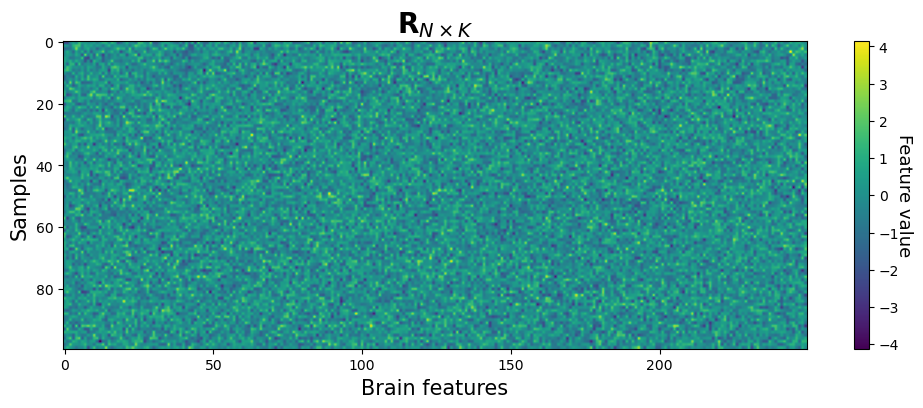

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.imshow(R, aspect='auto')
plt.xlabel('Brain features', fontsize=15)
plt.ylabel('Samples', fontsize=15)
plt.title(r'$\mathbf{R}_{N\times K}$', fontsize=20)
cbar = plt.colorbar()
cbar.set_label('Feature value', fontsize=13, rotation=270, labelpad=10)
plt.show()

<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): Extract the pattern of the 42nd trial and store it in a variable called <tt>trial42</tt>. Then, extract the values of 187th brain feature across all trials and store it in a variable called <tt>feat187</tt>. Lastly, extract feature value of the 60th trial and the 221nd feature and store it in a variable called <tt>t60_f221</tt>. Remember: Python uses zero-based indexing (first value in an array is indexed by 0)!
</div>

In [20]:
trial42 = R[41,:]
feat187 = R[:,186]
t60_f221 = R[59,220:221]

In [21]:
''' Tests the above ToDo. '''
from niedu.tests.nipa.week_1 import test_R_indexing
test_R_indexing(R, trial42, feat187, t60_f221)

Well done!


Alright, to practice a little bit more. We included whole-brain VBM data for 20 subjects in the `vbm/` subfolder:

In [22]:
import os
sorted(os.listdir('vbm'))

['sub-01.nii.gz',
 'sub-02.nii.gz',
 'sub-03.nii.gz',
 'sub-04.nii.gz',
 'sub-05.nii.gz',
 'sub-06.nii.gz',
 'sub-07.nii.gz',
 'sub-08.nii.gz',
 'sub-09.nii.gz',
 'sub-10.nii.gz',
 'sub-11.nii.gz',
 'sub-12.nii.gz',
 'sub-13.nii.gz',
 'sub-14.nii.gz',
 'sub-15.nii.gz',
 'sub-16.nii.gz',
 'sub-17.nii.gz',
 'sub-18.nii.gz',
 'sub-19.nii.gz',
 'sub-20.nii.gz']

The VBM data represents spatially normalized (to MNI152, 2mm), whole-brain voxelwise gray matter volume estimates (read more about VBM [here](https://en.wikipedia.org/wiki/Voxel-based_morphometry)).

Let's inspect the data from a single subject:

Shape of Nifti file:  (91, 109, 91)


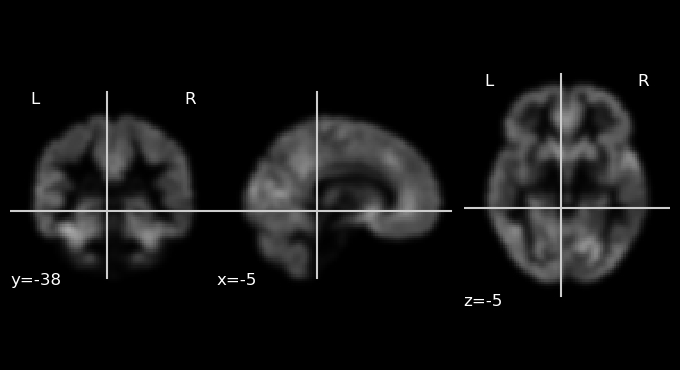

In [23]:
import os
import nibabel as nib
from nilearn import plotting

sub_01_vbm_path = os.path.join('vbm', 'sub-01.nii.gz')
sub_01_vbm = nib.load(sub_01_vbm_path)
print("Shape of Nifti file: ", sub_01_vbm.shape)

# Let's plot it as well
plotting.plot_anat(sub_01_vbm)
plt.show()

As you can see, the VBM data is a 3D array of shape 91 ($X$) $\times$ 109 ($Y$) $\times$ 91 ($Z$) (representing voxels). These are the spatial dimensions associated with the standard MNI152 (2 mm) template provided by FSL. As VBM is structural (not functional!) data, there is no time dimension ($T$).

Now, suppose that we want to do a pattern analysis on the data of all 20 subjects. We should then create a 2D array of shape 20 (subjects) $\times\ K$ (number of voxels, i.e., $91 \times 109 \times 91$). To do so, we need to create a loop over all files, load them in, "flatten" the data, and ultimately stack them into a 2D array. 

Before you'll implement this as part of the next ToDo, we will show you a neat Python function called `glob`, which allows you to simply find files using "[wildcards](https://en.wikipedia.org/wiki/Wildcard_character)":

In [24]:
from glob import glob

It works as follows:

```
list_of_files = glob('path/with/subdirectories/*/*.nii.gz')
```

Importantly, the string you pass to `glob` can contain one or more wildcard characters (such as `?` or `*`). Also, *the returned list is not sorted*! Let's try to get all our VBM subject data into a list using this function:

In [25]:
# Let's define a "search string"; we'll use the os.path.join function
# to make sure this works both on Linux/Mac and Windows
search_str = os.path.join('vbm', 'sub-*.nii.gz')
vbm_files = glob(search_str)

# this is also possible: vbm_files = glob(os.path.join('vbm', 'sub-*.nii.gz'))

# Let's print the returned list
print(vbm_files)

['vbm/sub-12.nii.gz', 'vbm/sub-02.nii.gz', 'vbm/sub-10.nii.gz', 'vbm/sub-14.nii.gz', 'vbm/sub-18.nii.gz', 'vbm/sub-06.nii.gz', 'vbm/sub-20.nii.gz', 'vbm/sub-04.nii.gz', 'vbm/sub-16.nii.gz', 'vbm/sub-08.nii.gz', 'vbm/sub-13.nii.gz', 'vbm/sub-01.nii.gz', 'vbm/sub-03.nii.gz', 'vbm/sub-11.nii.gz', 'vbm/sub-15.nii.gz', 'vbm/sub-07.nii.gz', 'vbm/sub-19.nii.gz', 'vbm/sub-05.nii.gz', 'vbm/sub-09.nii.gz', 'vbm/sub-17.nii.gz']


As you can see, *the list is not alphabetically sorted*, so let's fix that with the `sorted` function:

In [26]:
vbm_files = sorted(vbm_files)
print(vbm_files)
# Note that we could have done that with a single statement
# vbm_files = sorted(glob(os.path.join('vbm', 'sub-*.nii.gz')))
# But also remember: shorter code is not always better!

['vbm/sub-01.nii.gz', 'vbm/sub-02.nii.gz', 'vbm/sub-03.nii.gz', 'vbm/sub-04.nii.gz', 'vbm/sub-05.nii.gz', 'vbm/sub-06.nii.gz', 'vbm/sub-07.nii.gz', 'vbm/sub-08.nii.gz', 'vbm/sub-09.nii.gz', 'vbm/sub-10.nii.gz', 'vbm/sub-11.nii.gz', 'vbm/sub-12.nii.gz', 'vbm/sub-13.nii.gz', 'vbm/sub-14.nii.gz', 'vbm/sub-15.nii.gz', 'vbm/sub-16.nii.gz', 'vbm/sub-17.nii.gz', 'vbm/sub-18.nii.gz', 'vbm/sub-19.nii.gz', 'vbm/sub-20.nii.gz']


<div class='alert alert-warning'>
    <b>ToDo</b> (2 points): Create a 2D array with the vertically stacked subject-specific (flattened) VBM patterns, in which the first subject should be the first row. You may want to pre-allocate this array before starting your loop (using, e.g., <tt>np.zeros</tt>). Also, the <tt>enumerate</tt> function may be useful when writing your loop. Try to google how to flatten an N-dimensional array into a single vector. Store the final 2D array in a variable named <tt>R_vbm</tt>.
</div>

In [30]:
np.multiply(91,9919)

902629

In [69]:
R_vbm = np.zeros(shape=(20, 902629))
for i in enumerate(vbm_files):
    file = nib.load(i[1])
    file_1 = file.get_fdata()
    file_2 = file_1.flatten()
    R_vbm[i[0]] = file_2

In [70]:
''' Tests the above ToDo. '''
from niedu.tests.nipa.week_1 import test_R_vbm_loop
test_R_vbm_loop(R_vbm)

Well done!


<div class='alert alert-success'>
    <b>Tip</b>: While it is a good exercise to load in the data yourself, you can also easily load in and concatenate a set of Nifti files using Nilearn's <a href="https://nilearn.github.io/modules/generated/nilearn.image.concat_imgs.html">concat_imgs</a> function (which returns a 4D <tt>Nifti1Image</tt>, with the different patterns as the fourth dimension). You'd still have to reorganize this data into a 2D array, though.
</div>

In [71]:
# Run this cell after you're done with the ToDo
# This will remove the all numpy arrays from memory,
# clearing up RAM for the next sections
%reset -f array

### Patterns as "points in space"
Before we continue with the topic of pattern estimation, there is one idea that we'd like to introduce: thinking of patterns as points (i.e., coordinates) in space. Thinking of patterns this way is helpful to understanding both machine learning based analyses and representational similarity analysis. While for some, this idea might sound trivial, we believe it's worth going over anyway. Now, let's make this idea more concrete. 

Suppose we have estimated fMRI activity patterns for 20 trials (rows of $\mathbf{R}$). Now, we will also assume that those patterns consist of only two features (e.g., voxels; columns of $\mathbf{R}$), because this will make visualizing patterns as points in space easier than when we choose a larger number of features.

Alright, let's simulate and visualize the data (as a 2D array):

Shape of R: (20, 2)


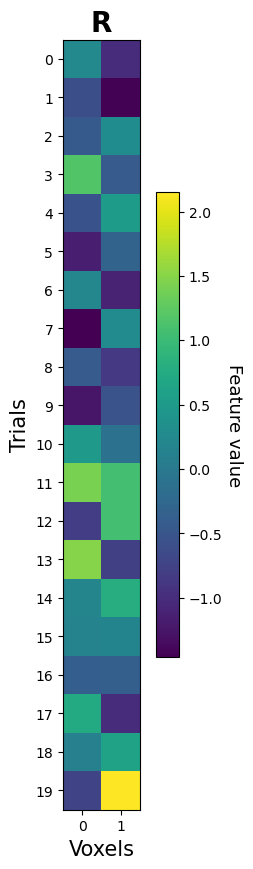

In [72]:
K = 2  # features (voxels)
N = 20  # samples (trials)

R = np.random.multivariate_normal(np.zeros(K), np.eye(K), size=N)

print("Shape of R:", R.shape)

# Plot 2D array as heatmap
fig, ax = plt.subplots(figsize=(2, 10))
mapp = ax.imshow(R)
cbar = fig.colorbar(mapp, pad=0.1)
cbar.set_label('Feature value', fontsize=13, rotation=270, labelpad=15)
ax.set_yticks(np.arange(N))
ax.set_xticks(np.arange(K))
ax.set_title(r"$\mathbf{R}$", fontsize=20)
ax.set_xlabel('Voxels', fontsize=15)
ax.set_ylabel('Trials', fontsize=15)
plt.show()

Now, we mentioned that each pattern (row of $\mathbf{R}$, i.e., $\mathbf{R}_{i}$) can be interpreted as a point in 2D space. With space, here, we mean a space where each feature (e.g., voxel; column of $\mathbf{R}$, i.e., $\mathbf{R}_{j}$) represents a separate axis. In our simulated data, we have two features (e.g., voxel 1 and voxel 2), so our space will have two axes:

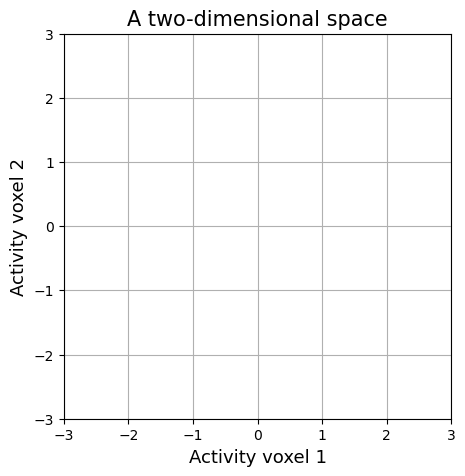

In [73]:
plt.figure(figsize=(5, 5))
plt.title("A two-dimensional space", fontsize=15)
plt.grid()
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.xlabel('Activity voxel 1', fontsize=13)
plt.ylabel('Activity voxel 2', fontsize=13)
plt.show()

Within this space, each of our patterns (samples) represents a point. The values of each pattern represent the *coordinates* of its location in this space. For example, the coordinates of the first pattern are:

In [74]:
print(R[0, :])

[ 0.24040352 -1.00233531]


As such, we can plot this pattern as a point in space:

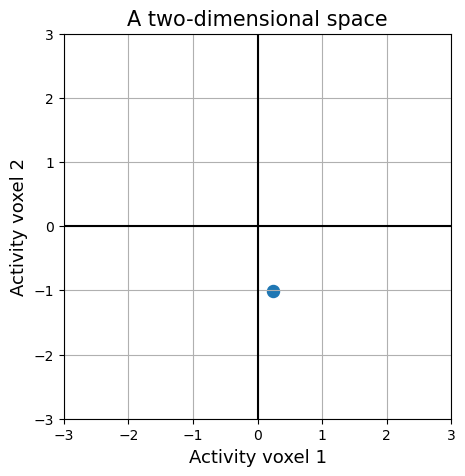

In [75]:
plt.figure(figsize=(5, 5))
plt.title("A two-dimensional space", fontsize=15)
plt.grid()

# We use the "scatter" function to plot this point, but
# we could also have used plt.plot(R[0, 0], R[0, 1], marker='o')
plt.scatter(R[0, 0], R[0, 1], marker='o', s=75)
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.xlabel('Activity voxel 1', fontsize=13)
plt.ylabel('Activity voxel 2', fontsize=13)

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

If we do this for all patterns, we get an ordinary scatter plot of the data:

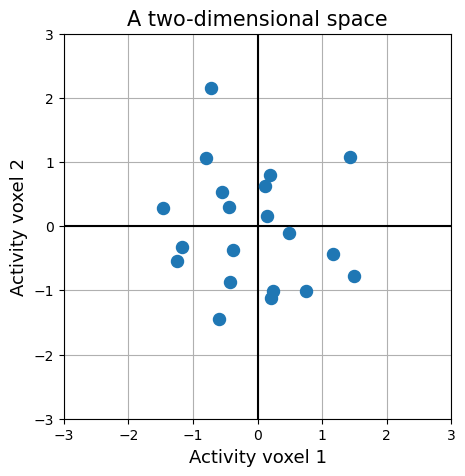

In [76]:
plt.figure(figsize=(5, 5))
plt.title("A two-dimensional space", fontsize=15)
plt.grid()

# We use the "scatter" function to plot this point, but
# we could also have used plt.plot(R[0, 0], R[0, 1], marker='o')
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.scatter(R[:, 0], R[:, 1], marker='o', s=75, zorder=3)
plt.xlabel('Activity voxel 1', fontsize=13)
plt.ylabel('Activity voxel 2', fontsize=13)

plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.show()

It is important to realize that both perspectives &mdash; as a 2D array and as a set of points in $K$-dimensional space &mdash; represents the same data! Practically, pattern analysis algorithms usually expect the data as a 2D array, but (in our experience) the operations and mechanisms implemented by those algorithms are easiest to explain and to understand from the "points in space" perspective.

You might think, "but how does this work for data with more than two features?" Well, the idea of patterns as points in space remains the same: each feature represents a new dimension (or "axis"). For three features, this means that a pattern represents a point in 3D (X, Y, Z) space; for four features, a pattern represents a point in 4D space (like a point moving in 3D space) ... but what about a pattern with 14 features? Or 500? Actually, this is impossible to visualize or even make sense of mentally. As the famous artificial intelligence researcher Geoffrey Hinton put it:

> "To deal with ... a 14 dimensional space, visualize a 3D space and say 'fourteen' very loudly. Everyone does it." (Geoffrey Hinton)

The important thing to understand, though, is that most operations, computations, and algorithms that deal with patterns do not care about whether your data is 2D (two features) or 14D (fourteen features) &mdash; we just have to trust the mathematicians that whatever we do on 2D data will generalize to $K$-dimensional data :-)

That said, people still try to visualize >2D data using *dimensionality reduction* techniques. These techniques try to project data to a lower-dimensional space. For example, you can transform a dataset with 500 features (i.e., a 500-dimensional dataset) to a 2D dimensional dataset using techniques such as principal component analysis (PCA), Multidimensional Scaling (MDS), and t-SNE. For example, PCA tries to a subset of uncorrelated lower-dimensional features (e.g., 2) from  linear combinations of high-dimensional features (e.g., 4) that still represent as much variance of the high-dimensional components as possible. We'll show you an example below using an implementation of PCA from the machine learning library [scikit-learn](https://scikit-learn.org/stable/), which we'll use extensively in next week's lab:

Shape R4D: (100, 4)
Shape R2D: (100, 2)


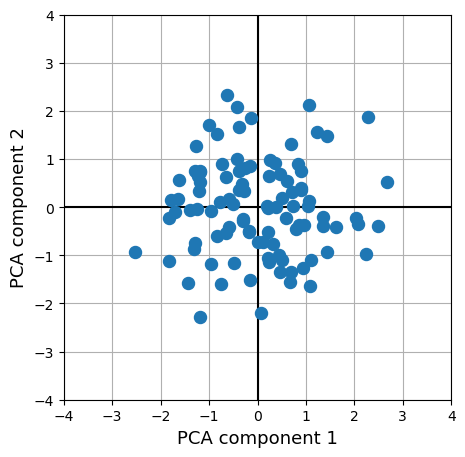

In [77]:
from sklearn.decomposition import PCA

# Let's create a dataset with 100 samples and 4 features
R4D = np.random.normal(0, 1, size=(100, 4))
print("Shape R4D:", R4D.shape)

# We'll instantiate a PCA object that will
# transform our data into 2 components
pca = PCA(n_components=2)

# Fit and transform the data from 4D to 2D
R2D = pca.fit_transform(R4D)
print("Shape R2D:", R2D.shape)

# Plot the result
plt.figure(figsize=(5, 5))
plt.scatter(R2D[:, 0], R2D[:, 1], marker='o', s=75, zorder=3)
plt.axhline(0, c='k')
plt.axvline(0, c='k')
plt.xlabel('PCA component 1', fontsize=13)
plt.ylabel('PCA component 2', fontsize=13)
plt.grid()
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

<div class='alert alert-warning'>
    <b>ToDo</b> (optional): As discussed, PCA is a specific dimensionality reduction technique that uses linear combinations of features to project the data to a lower-dimensional space with fewer "components". Linear combinations are simply weighted sums of high-dimensional features. In a 4D dimensional space that is project to 2D, PCA component 1 might be computed as $\mathbf{R}_{j=1}\theta_{1}+\mathbf{R}_{j=2}\theta_{2}+\mathbf{R}_{j=3}\theta_{3}+\mathbf{R}_{j=4}\theta_{4}$, where $R_{j=1}$ represents the 4th feature of $\mathbf{R}$ and $\theta_{1}$ represents the <em>weight</em> for the 4th feature.
    
The weights of the fitted PCA model can be accessed by, confusingly, <tt>pca.components_</tt> (shape: $K_{lower} \times K_{higher}$. Using these weights, can you recompute the lower-dimensional features from the higher-dimensional features yourself? Try to plot it like the figure above and check whether it matches.
</div>

In [ ]:
''' Implement the (optional) ToDo here. '''
# YOUR CODE HERE
raise NotImplementedError()

Note that dimensionality reduction is often used for visualization, but it can also be used as a preprocessing step in pattern analyses. We'll take a look this in more detail next week.

Alright, back to the topic of pattern extraction/estimation. You saw that preparing VBM data for (between-subject) pattern analyses is actually quite straightforward, but unfortunately, preparing functional MRI data for pattern analysis is a little more complicated. The reason is that we are dealing with time series in which different trials ($N$) are "embedded". The next section discusses different methods to "extract" (estimate) these trial-wise patterns.

## Estimating patterns
As we mentioned before, we should prepare our data as an $N$ (samples) $\times$ $K$ (features) array. With fMRI data, our data is formatted as a $X \times Y \times Z \times T$ array; we can flatten the $X$, $Y$, and $Z$ dimensions, but we still have to find a way to "extract" patterns for our $N$ trials from the time series (i.e., the $T$ dimension). 

### Important side note: single trials vs. (runwise) average trials
In this section, we often assume that our "samples" refer to different *trials*, i.e., single instances of a stimulus or response (or another experimentally-related factor). This is, however, not the only option. Sometimes, researchers choose to treat multiple repetitions of a trial as a single sample or multiple trials within a condition as a single sample. For example, suppose you design a simple passive-viewing experiment with images belonging two one of three conditions: faces, houses, and chairs. Each condition has ten exemplars (face1, face2, ..., face10, house1, house2, ..., house10, chair1, chair2, ... , chair10) and each exemplar/item is repeated six times. So, in total there are 3 (condition) $\times$ 10 (examplars) $\times$ 6 (repetitions) = 180 trials. Because you don't want to bore the participant to death, you split the 180 trials into two runs (90 each).
    
Now, there are different ways to define your samples. One is to treat every single trial as a sample (so you'll have a 180 samples). Another way is to treat each exemplar as a sample. If you do so, you'll have to "pool" the pattern estimates across all 6 repetitions (so you'll have $10 \times 3 = 30$ samples). And yet another way is to treat each condition as a sample, so you'll have to pool the pattern estimates across all 6 repetitions and 10 exemplars per condition (so you'll end up with only 3 samples). Lastly, with respect to the latter two approaches, you may choose to only average repetitions and/or exemplars *within* runs. So, for two runs, you end up with either $10 \times 3 \times 2 = 60$ samples (when averaging across repetitions only) or $3 \times 2 = 6$ samples (when averaging across examplars and repetitions).

Whether you should perform your pattern analysis on the trial, examplar, or condition level, and whether you should estimate these patterns across runs or within runs, depends on your research question and analysis technique. For example, if you want to decode exemplars from each other, you obviously should not average across exemplars. Also, some experiments may not have different exemplars per condition (or do not have categorical conditions at all). With respect to the importance of analysis technique: when applying machine learning analyses to fMRI data, people often prefer to split their trials across many (short) runs and &mdash; if using a categorical design &mdash; prefer to estimate a single pattern per run. This is because samples across runs are not temporally autocorrelated, which is an important assumption in machine learning based analyses. Lastly, for any pattern analysis, averaging across different trials will increase the signal-to-noise ratio (SNR) for any sample (because you average out noise), but will decrease the statistical power of the analysis (because you have fewer samples). 

Long story short: whatever you treat as a sample &mdash; single trials, (runwise) exemplars or (runwise) conditions &mdash; depends on your design, research question, and analysis technique. In the rest of the tutorial, we will usually refer to samples as "trials", as this scenario is easiest to simulate and visualize, but remember that this term may equally well refer to (runwise) exemplar-average or condition-average patterns.

---

To make the issue of estimating patterns from time series a little more concrete, let's simulate some signals. We'll assume that we have a very simple experiment with two conditions (A, B) with ten trials each (interleaved, i.e., ABABAB...AB), a trial duration of 1 second, spaced evenly within a single run of 200 seconds (with a TR of 2 seconds, so 100 timepoints). Note that you are not necessarily limited to discrete categorical designs for all pattern analyses! While for machine learning-based methods (topic of week 2) it is common to have a design with a single categorical feature of interest (or some times a single continuous one),  representional similarity analyses (topic of week 3) are often applied to data with more "rich" designs (i.e., designs that include many, often continuously varying, factors of interest). Also, using twenty trials is probably way too few for any pattern analysis, but it'll make the examples (and visualizations) in this section easier to understand. 

Alright, let's get to it.

In [78]:
TR = 2
N = 20  # 2 x 10 trials
T = 200  # duration in seconds

# t_pad is a little baseline at the 
# start and end of the run
t_pad = 10

onsets = np.linspace(t_pad, T - t_pad, N, endpoint=False)
durations = np.ones(onsets.size)
conditions = ['A', 'B'] * (N // 2)

print("Onsets:", onsets, end='\n\n')
print("Conditions:", conditions)

Onsets: [ 10.  19.  28.  37.  46.  55.  64.  73.  82.  91. 100. 109. 118. 127.
 136. 145. 154. 163. 172. 181.]

Conditions: ['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B', 'A', 'B']


We'll use the `simulate_signal` function used in the introductory course to simulate the data. This function is like a GLM in reverse: it assumes that a signal ($R$) is generated as a linear combination between (HRF-convolved) experimental features ($\mathbf{S}$) weighted by some parameters ( $\beta$ ) plus some additive noise ($\epsilon$), and simulates the signal accordingly (you can check out the function by running `simulate_signal??` in a new code cell). 

Because we simulate the signal, we can use "ground-truth" activation parameters ( $\beta$ ). In this simulation, we'll determine that the signal responds more strongly to trials of condition A ($\beta = 0.8$) than trials of condition B ($\beta = 0.2$) in *even* voxels (voxel 0, 2, etc.) and vice versa for *odd* voxels (voxel 1, 3, etc.):

In [79]:
params_even = np.array([0.8, 0.2])
params_odd = 1 - params_even

<div class='alert alert-info'>
    <b>ToThink</b> (0 points): Given these simulation parameters, what do you think that the corresponding $N\times K$ pattern array ($\mathbf{R}$) would roughly look like visually (assuming an efficient pattern estimation method)?
</div>

Alright, We simulate some data for, let's say, four voxels ($K = 4$). (Again, you'll usually perform pattern analyses on many more voxels.) 

In [80]:
from niedu.utils.nii import simulate_signal
K = 4

ts = []
for i in range(K):

    # Google "Python modulo" to figure out
    # what the line below does!
    is_even = (i % 2) == 0
    
    sig, _ = simulate_signal(
        onsets,
        conditions,
        duration=T,
        plot=False,
        std_noise=0.25,
        params_canon=params_even if is_even else params_odd
    )

    ts.append(sig[:, np.newaxis])

# ts = timeseries
ts = np.hstack(ts)
print("Shape of simulated signals: ", ts.shape)

Shape of simulated signals:  (100, 4)


And let's plot these voxels. We'll show the trial onsets as arrows (red = condition A, orange = condition B):

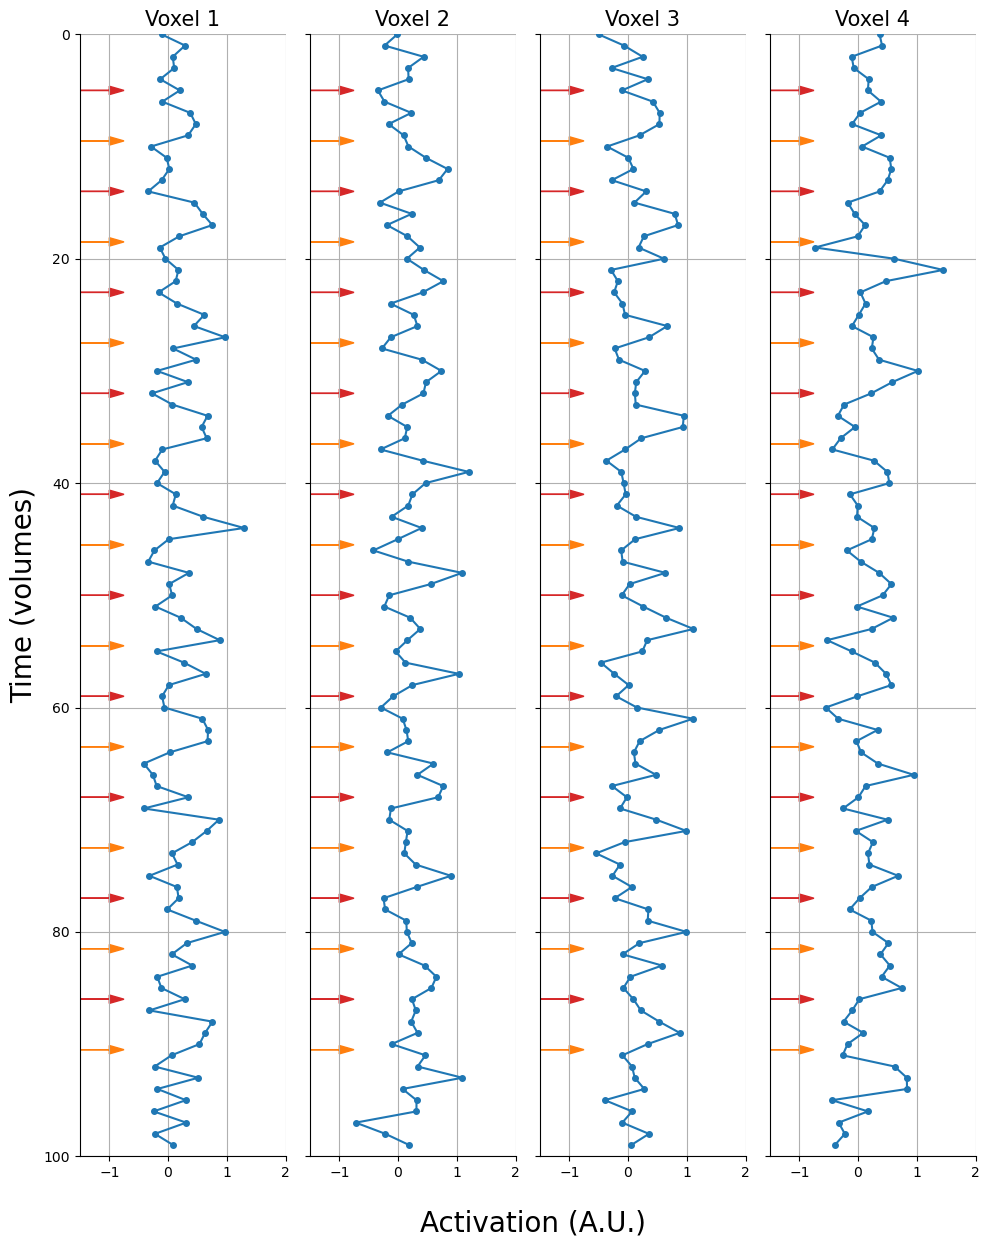

In [83]:
import seaborn as sns

fig, axes = plt.subplots(ncols=K, sharex=True, sharey=True, figsize=(10, 12))
t = np.arange(ts.shape[0])

for i, ax in enumerate(axes.flatten()):
    # Plot signal
    ax.plot(ts[:, i], t, marker='o', ms=4, c='tab:blue')
    # Plot trial onsets (as arrows)
    for ii, to in enumerate(onsets):
        color = 'tab:red' if ii % 2 == 0 else 'tab:orange'
        ax.arrow(-1.5, to / TR, dy=0, dx=0.5, color=color, head_width=0.75, head_length=0.25)

    ax.set_xlim(-1.5, 2)
    ax.set_ylim(0, ts.shape[0])
    ax.grid()
    ax.set_title(f'Voxel {i+1}', fontsize=15)
    ax.invert_yaxis()
    if i == 0:
        ax.set_ylabel("Time (volumes)", fontsize=20)
    
# Common axis labels
fig.text(0.425, -.03, "Activation (A.U.)", fontsize=20)
fig.tight_layout()
sns.despine()
plt.show()

<div class='alert alert-success'>
    <b>Tip</b>: Matplotlib is a very flexible plotting package, but arguably at the expense of how fast you can implement something. <a href="https://seaborn.pydata.org/">Seaborn</a> is a great package (build on top of Matplotlib) that offers some neat functionality that makes your life easier when plotting in Python. For example, we used the <tt>despine</tt> function to remove the top and right spines to make our plot a little nicer. In this course, we'll mostly use Matplotlib, but we just wanted to make you aware of this awesome package.
</div>

Alright, now we can start discussing methods for pattern estimation! Unfortunately, as pattern analyses are relatively new, there no concensus yet about the "best" method for pattern estimation. In fact, there exist many different methods, which we can roughly divided into two types:

1. Timepoint-based method (for lack of a better name) and
2. GLM-based methods

We'll discuss both of them, but spend a little more time on the latter set of methods as they are more complicated (and are more popular).

### Timepoint-based methods
Timepoint-based methods "extract" patterns by simply using a single timepoint (e.g., 6 seconds after stimulus presentation) or (an average of) multiple timepoints (e.g., 4, 6, and 8 seconds after stimulus presentation). 

Below, we visualize what a single-timepoint method would look like (assuming that we'd want to extract the timepoint 6 seconds after stimulus presentation, i.e., around the assumed peak of the BOLD response). The stars represent the values that we would extract (red when condition A, orange when condition B). Note, we only plot the first 60 volumes.

In [ ]:
fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(10, 12))
t_fmri = np.linspace(0, T, ts.shape[0], endpoint=False)
t = np.arange(ts.shape[0])

for i, ax in enumerate(axes.flatten()):
    # Plot signal
    ax.plot(ts[:, i], t, marker='o', ms=4, c='tab:blue')
    # Plot trial onsets (as arrows)
    for ii, to in enumerate(onsets):
        plus6 = np.interp(to+6, t_fmri, ts[:, i])
        color = 'tab:red' if ii % 2 == 0 else 'tab:orange'
        ax.arrow(-1.5, to / TR, dy=0, dx=0.5, color=color, head_width=0.75, head_length=0.25)
        ax.plot([plus6, plus6], [(to+6) / TR, (to+6) / TR], marker='*', ms=15, c=color)
    
    ax.set_xlim(-1.5, 2)
    ax.set_ylim(0, ts.shape[0] // 2)
    ax.grid()
    ax.set_title(f'Voxel {i+1}', fontsize=15)
    ax.invert_yaxis()
    if i == 0:
        ax.set_ylabel("Time (volumes)", fontsize=20)

# Common axis labels
fig.text(0.425, -.03, "Activation (A.U.)", fontsize=20)
fig.tight_layout()
sns.despine()
plt.show()

Now, extracting these timepoints 6 seconds after stimulus presentation is easy when this timepoint is a multiple of the scan's TR (here: 2 seconds). For example, to extract the value for the first trial (onset: 10 seconds), we simply take the 8th value in our timeseries, because $(10 + 6) / 2 = 8$. But what if our trial onset + 6 seconds is *not* a multiple of the TR, such as with trial 2 (onset: 19 seconds)? Well, we can interpolate this value! We will use the same function for this operation as we did for slice-timing correction (from the previous course): `interp1d` from the `scipy.interpolate` module.

To refresh your memory: this function takes the timepoints associated with the values (or "frame_times" in Nilearn lingo) and the values itself to generate a new object which we'll later use to do the actual (linear) interpolation. First, let's define the timepoints:

In [ ]:
t_fmri = np.linspace(0, T, ts.shape[0], endpoint=False)

<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): The above timepoints assume that all data was acquired at the onset of the volume acquisition ($t=0$, $t=2$, etc.). Suppose that we actually slice-time corrected our data to the middle slice, i.e., the 18th slice (out of 36 slices) &mdash; create a new array (using <tt>np.linspace</tt> with timepoints that reflect these slice-time corrected acquisition onsets) and store it in a variable named <tt>t_fmri_middle_slice</tt>.
</div>

In [ ]:
''' Implement your ToDo here. '''
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
''' Tests the above ToDo. '''
from niedu.tests.nipa.week_1 import test_frame_times_stc
test_frame_times_stc(TR, T, ts.shape[0], t_fmri_middle_slice)

For now, let's assume that all data was actually acquired at the start of the volume ($t=0$, $t=2$, etc.). We can "initialize" our interpolator by giving it both the timepoints (`t_fmri`) and the data (`ts`). Note that `ts` is not a single time series, but a 2D array with time series for four voxels (across different columns). By specifying `axis=0`, we tell `interp1d` that the first axis represents the axis that we want to interpolate later:

In [ ]:
from scipy.interpolate import interp1d
interpolator = interp1d(t_fmri, ts, axis=0)

Now, we can give the `interpolator` object any set of timepoints and it will return the linearly interpolated values associated with these timepoints for all four voxels. Let's do this for our trial onsets plus six seconds:

In [ ]:
onsets_plus_6 = onsets + 6
R_plus6 = interpolator(onsets_plus_6)
print("Shape extracted pattern:", R_plus6.shape)

fig, ax = plt.subplots(figsize=(2, 10))
mapp = ax.imshow(R_plus6)
cbar = fig.colorbar(mapp)
cbar.set_label('Feature value', fontsize=13, rotation=270, labelpad=15)
ax.set_yticks(np.arange(N))
ax.set_xticks(np.arange(K))
ax.set_title(r"$\mathbf{R}$", fontsize=20)
ax.set_xlabel('Voxels', fontsize=15)
ax.set_ylabel('Trials', fontsize=15)
plt.show()

Yay, we have extracted our first pattern! Does it look like what you expected given the known mean amplitude of the trials from the two conditions ($\beta_{\mathrm{A,even}} = 0.8, \beta_{\mathrm{B,even}} = 0.2$ and vice versa for odd voxels)?

<div class='alert alert-warning'>
    <b>ToDo</b> (3 points): An alternative to the single-timepoint method is to extract, per trial, the <em>average</em> activity within a particular time window, for example 5-7 seconds post-stimulus. One way to do this is by perform interpolation in steps of (for example) 0.1 within the 5-7 post-stimulus time window (i.e., $5.0, 5.1, 5.2, \dots , 6.8, 6.9, 7.0$) and subsequently averaging these values, per trial, into a single activity estimate. Below, we defined these different steps (<tt>t_post_stimulus</tt>) for you already. Use the <tt>interpolator</tt> object to extract the timepoints for these different post-stimulus times relative to our onsets (<tt>onsets</tt> variable) from our data (<tt>ts</tt> variable). Store the extracted patterns in a new variable called <tt>R_av</tt>.
    
Note: this is a relatively difficult ToDo! Consider skipping it if it takes too long.
</div>

In [ ]:
''' Implement your ToDo here. '''
t_post_stimulus = np.linspace(5, 7, 21, endpoint=True)
print(t_post_stimulus)

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
''' Tests the above ToDo. '''
from niedu.tests.nipa.week_1 import test_average_extraction
test_average_extraction(onsets, ts, t_post_stimulus, interpolator, R_av)

These timepoint-based methods are relatively simple to implement and computationally efficient. Another variation that you might see in the literature is that extracted (averages of) timepoints are baseline-subtracted ($\mathbf{R}_{i} - \mathrm{baseline}_{i}$) or baseline-normalized ($\frac{\mathbf{R}_{i}}{\mathrm{baseline}_{i}}$), where the baseline is usually chosen to be at the stimulus onset or a small window before the stimulus onset. This technique is, as far as we know, not very popular, so we won't discuss it any further in this lab.

### GLM-based methods
One big disadvantage of timepoint-based methods is that it cannot disentangle activity due to different sources (such as trials that are close in time), which is a major problem for fast (event-related) designs. For example, if you present a trial at $t=10$ and another at $t=12$ and subsequently extract the pattern six seconds post-stimulus (at $t=18$ for the second trial), then the activity estimate for the second trial is definitely going to contain activity due to the first trial because of the sluggishness of the HRF. 

As such, nowadays GLM-based pattern estimation techniques, which *can* disentangle the contribution of different sources, are more popular than timepoint-based methods. (Although, technically, you can use timepoint-based methods using the GLM with FIR-based designs, but that's beyond the scope of this course.) Again, there are multiple flavors of GLM-based pattern estimation, of which we'll discuss the two most popular ones.

#### Least-squares all (LSA)
The most straightforward GLM-based pattern estimation technique is to fit a single GLM with a design matrix that contains one or more regressors for each sample that you want to estimate (in addition to any confound regressors). The estimated parameters ($\hat{\beta}$) corresponding to our samples from this GLM &mdash; representing the relative (de)activation of each voxel for each trial &mdash; will then represent our patterns! 

This technique is often reffered to as "least-squares all" (LSA). Note that, as explained before, a sample can refer to either a single trial, a set of repetitions of a particuar exemplar, or even a single condition. For now, we'll assume that samples refer to single trials. Often, each sample is modelled by a single (canonical) HRF-convolved regressor (but you could also use more than one regressor, e.g., using a basis set with temporal/dispersion derivatives or a FIR-based basis set), so we'll focus on this approach.

Let's go back to our simulated data. We have a single run containing 20 trials, so ultimately our design matrix should contain twenty columns: one for every trial. We can use the `make_first_level_design_matrix` function from Nilearn to create the design matrix. Importantly, we should make sure to give a separate and unique "trial_type" values for all our trials. If we don't do this (e.g., set trial type to the trial condition: "A" or "B"), then Nilearn won't create separate regressors for our trials.

In [ ]:
import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix

# We have to create a dataframe with onsets/durations/trial_types
# No need for modulation!
events_sim = pd.DataFrame(onsets, columns=['onset'])
events_sim.loc[:, 'duration'] = 1
events_sim.loc[:, 'trial_type'] = ['trial_' + str(i).zfill(2) for i in range(1, N+1)]

# lsa_dm = least squares all design matrix
lsa_dm = make_first_level_design_matrix(
    frame_times=t_fmri,  # we defined this earlier for interpolation!
    events=events_sim,
    hrf_model='glover',
    drift_model=None  # assume data is already high-pass filtered
)

# Check out the created design matrix
# Note that the index represents the frame times
lsa_dm

Note that the design matrix contains 21 regressors: 20 trialwise regressors and an intercept (the last column). Let's also plot it using Nilearn:

In [ ]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(lsa_dm);

And, while we're at it, plot it as time series (rather than a heatmap):

In [ ]:
fig, ax = plt.subplots(figsize=(12, 12))
for i in range(lsa_dm.shape[1]):
    ax.plot(i + lsa_dm.iloc[:, i], np.arange(ts.shape[0]))

ax.set_title("LSA design matrix", fontsize=20)
ax.set_ylim(0, lsa_dm.shape[0]-1)
ax.set_xlabel('')
ax.set_xticks(np.arange(N+1))
ax.set_xticklabels(['trial ' +  str(i+1) for i in range(N)] + ['icept'], rotation=-90)
ax.invert_yaxis()
ax.grid()
ax.set_ylabel("Time (volumes)", fontsize=15)
plt.show()

<div class='alert alert-warning'>
    <b>ToDo/ToThink</b> (2 points): One "problem" with LSA-type design matrices, especially in fast event-related designs, is that they are not very statistically <em>efficient</em>, i.e., they lead to relatively high variance estimates of your parameters ($\hat{\beta}$), mainly due to relatively high predictor variance. Because we used a fixed inter-trial interval (here: 9 seconds), the correlation between "adjacent" trials are (approximately) the same. <br>
    
Compute the correlation between, for example, the predictors associated with trial 1 and trial 2, using the <tt>pearsonr</tt> function imported below, and store it in a variable named <tt>corr_t1t2</tt> (1 point). Then, try to think of a way to improve the efficiency of this particular LSA design and write it down in the cell below the test cell.
</div>

In [ ]:
''' Implement your ToDO here. '''
# For more info about the `pearsonr` function, check
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html
# Want a challenge? Try to compute the correlation from scratch!
from scipy.stats import pearsonr

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
''' Tests the ToDo above. '''
from niedu.tests.nipa.week_1 import test_t1t2_corr
test_t1t2_corr(lsa_dm, corr_t1t2)

YOUR ANSWER HERE

Alright, let's actually fit the model! When dealing with real fMRI data, we'd use Nilearn to fit our GLM, but for now, we'll just use our own implementation of an (OLS) GLM. Note that we can actually fit a *single* GLM for all voxels at the same time by using `ts` (a $T \times K$ matrix) as our dependent variable due to the magic of linear algebra. In other words, we can run $K$ OLS models at once!

In [ ]:
# Let's use 'X', because it's shorter
X = lsa_dm.values

# Note we can fit our GLM for all K voxels at 
# the same time! As such, betas is not a vector,
# but an n_regressor x k_voxel matrix!
beta_hat_all = np.linalg.inv(X.T @ X) @ X.T @ ts
print("Shape beta_hat_all:", beta_hat_all.shape)

# Ah, the beta for the intercept is still in there
# Let's remove it
beta_icept = beta_hat_all[-1, :]
beta_hat = beta_hat_all[:-1, :]
print("Shape beta_hat (intercept removed):", beta_hat.shape)

Alright, let's visualize the estimated parameters ($\hat{\beta}$). We'll do this by plotting the scaled regressors (i.e., $X_{j}\hat{\beta}_{j}$) on top of the original signal. Each differently colored line represents a different regressor (so a different trial):

In [ ]:
fig, axes = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(10, 12))
t = np.arange(ts.shape[0])

for i, ax in enumerate(axes.flatten()):
    # Plot signal
    ax.plot(ts[:, i], t, marker='o', ms=4, lw=0.5, c='tab:blue')
    # Plot trial onsets (as arrows)
    for ii, to in enumerate(onsets):
        color = 'tab:red' if ii % 2 == 0 else 'tab:orange'
        ax.arrow(-1.5, to / TR, dy=0, dx=0.5, color=color, head_width=0.75, head_length=0.25)

    # Compute x*beta for icept only 
    scaled_icept = lsa_dm.iloc[:, -1].values * beta_icept[i]
    for ii in range(N):
        this_x = lsa_dm.iloc[:, ii].values
        # Compute x*beta for this particular trial (ii)
        xb = scaled_icept + this_x * beta_hat[ii, i]
        ax.plot(xb, t, lw=2)

    ax.set_xlim(-1.5, 2)
    ax.set_ylim(0, ts.shape[0] // 2)
    ax.grid()
    ax.set_title(f'Voxel {i+1}', fontsize=15)
    ax.invert_yaxis()
    if i == 0:
        ax.set_ylabel("Time (volumes)", fontsize=20)

# Common axis labels
fig.text(0.425, -.03, "Activation (A.U.)", fontsize=20)
fig.tight_layout()
sns.despine()
plt.show()

Ultimately, though, the estimated GLM parameters are just another way to estimate our pattern array ($\mathbf{R}$) &mdash; this time, we just estimated it using a different method (GLM-based) than before (timepoint-based). Therefore, let's visualize this array as we did with the other methods:

In [ ]:
fig, ax = plt.subplots(figsize=(2, 10))
mapp = ax.imshow(beta_hat)
cbar = fig.colorbar(mapp)
cbar.set_label(r'$\hat{\beta}$', fontsize=25, rotation=0, labelpad=10)
ax.set_yticks(np.arange(N))
ax.set_xticks(np.arange(K))
ax.set_title(r"$\mathbf{R}$", fontsize=20)
ax.set_xlabel('Voxels', fontsize=15)
ax.set_ylabel('Trials', fontsize=15)
plt.show()

<div class='alert alert-warning'>
    <b>ToDo</b> (optional, 0 points): It would be nice to visualize the patterns, but this is very hard because we have four dimenions (because we have four voxels)! <br><br>PCA to the rescue! Run PCA on the estimated patterns (<tt>beta_hat</tt>) and store the PCA-transformed  array (shape: $20 \times 2$) in a variable named <tt>beta_hat_2d</tt>. Then, try to plot the first two components as a scatterplot. Make it even nicer by plotting the trials from condition A as red points and trials from condition B als orange points. 
</div>

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
from niedu.tests.nipa.week_1 import test_pca_beta_hat
test_pca_beta_hat(beta_hat, beta_hat_2d)

#### Noise normalization
One often used preprocessing step for pattern analyses (using GLM-estimation methods) is to use "noise normalization" on the estimated patterns. There are two flavours: "univariate" and "multivariate" noise normalization. In univariate noise normalization, the estimated parameters ($\hat{\beta}$) are divided (normalized) by the standard deviation of the estimated parameters &mdash; which you might recognize as the formula for $t$-values (for a contrast against baseline)!

\begin{align}
t_{c\hat{\beta}} = \frac{c\hat{\beta}}{\sqrt{\hat{\sigma}^{2}c(X^{T}X)^{-1}c^{T}}}
\end{align}

where $\hat{\sigma}^{2}$ is the estimate of the error variance (sum of squared errors divided by the degrees of freedom) and $c(X^{T}X)^{-1}c^{T}$ is the "design variance". Sometimes people disregard the design variance and the degrees of freedom (DF) and instead only use the standard deviation of the noise: 

\begin{align}
t_{c\hat{\beta}} \approx \frac{c\hat{\beta}}{\sqrt{\sum (y_{i} - X_{i}\hat{\beta})^{2}}}
\end{align}

<div class='alert alert-info'>
    <b>ToThink</b> (1 point): When experiments use a fixed ISI (in the context of single-trial GLMs), the omission of the design variance in univariate noise normalization is warranted. Explain why.
</div>

YOUR ANSWER HERE

Either way, this univariate noise normalization is a way to "down-weigh" the uncertain (noisy) parameter estimates. Although this type of univariate noise normalization seems to lead to better results in both decoding and RSA analyses (e.g., [Misaki et al., 2010](https://www.ncbi.nlm.nih.gov/pubmed/20580933)), the jury is still out on this issue.

Multivariate noise normalization will be discussed in week 3 (RSA), so let's focus for now on the implementation of univariate noise normalization using the approximate method (which disregards design variance). To compute the standard deviation of the noise ($\sqrt{\sum (y_{i} - X_{i}\hat{\beta})^{2}}$), we first need to compute the noise, i.e., the unexplained variance ($y - X\hat{\beta}$) also known as the residuals:

In [ ]:
residuals = ts - X @ beta_hat_all
print("Shape residuals:", residuals.shape)

So, for each voxel ($K=4$), we have a timeseries ($T=100$) with unexplained variance ("noise"). Now, to get the standard deviation across all voxels, we can do the following:

In [ ]:
std_noise = np.std(residuals, axis=0)
print("Shape noise std:", std_noise.shape)

To do the actual normalization step, we simply divide the columns of the pattern matrix (`beta_hat`, which we estimated before) by the estimated noise standard deviation:

In [ ]:
# unn = univariate noise normalization
# Note that we don't have to do this for each trial (row) separately
# due to Numpy broadcasting!
R_unn = beta_hat / std_noise
print("Shape R_unn:", R_unn.shape)

And let's visualize it:

In [ ]:
fig, ax = plt.subplots(figsize=(2, 10))
mapp = ax.imshow(R_unn)
cbar = fig.colorbar(mapp)
cbar.set_label(r'$t$', fontsize=25, rotation=0, labelpad=10)
ax.set_yticks(np.arange(N))
ax.set_xticks(np.arange(K))
ax.set_title(r"$\mathbf{R}_{unn}$", fontsize=20)
ax.set_xlabel('Voxels', fontsize=15)
ax.set_ylabel('Trials', fontsize=15)
plt.show()

<div class='alert alert-info'>
    <b>ToThink</b> (1 point): In fact, univariate noise normalization didn't really change the pattern matrix much. Why do you think this is the case for our simulation data? Hint: check out the parameters for the simulation.
</div>

YOUR ANSWER HERE

#### LSA on real data
Alright, enough with all that fake data &mdash; let's work with some real data! We'll use the face perception task data from the *NI-edu* dataset, which we briefly mentioned in the fMRI-introduction course.

In the face perception task, participants were presented with images of faces (from the publicly available [Face Research Lab London Set](https://figshare.com/articles/Face_Research_Lab_London_Set/5047666)). In total, frontal face images from 40 different people ("identities") were used, which were either without expression ("neutral") or were smiling. Each face image (from in total 80 faces, i.e., 40 identities $\times$ 2, neutral/smiling) was shown, per participant, 6 times across the 12 runs (3 times per session). 

<div class='alert alert-info'>
    <b>Mini ToThink</b> (0 points): Why do you think we show the same image multiple times?
</div>

Identities were counterbalanced in terms of biological sex (male vs. female) and ethnicity (Caucasian vs. East-Asian vs. Black). The Face Research Lab London Set also contains the age of the people in the stimulus dataset and (average) attractiveness ratings for all faces from an independent set of raters. In addition, we also had our own participants rate the faces on perceived attractiveness, dominance, and trustworthiness after each session (rating each face, on each dimension, four times in total for robustness). The stimuli were chosen such that we have many different attributes that we could use to model brain responses (e.g., identity, expression, ethnicity, age, average attractiveness, and subjective/personal perceived attractiveness/dominance/trustworthiness).

In this paradigm, stimuli were presented for 1.25 seconds and had a fixed interstimulus interval (ISI) of 3.75 seconds. While sub-optimal for univariate "detection-based" analyses, we used a fixed ISI &mdash; rather than jittered &mdash; to make sure it can also be used for "single-trial" multivariate analyses. Each run contained 40 stimulus presentations. To keep the participants attentive, a random selection of 5 stimuli (out of 40) were followed by a rating on either perceived attractiveness, dominance, or trustworthiness using a button-box with eight buttons (four per hand) lasting 2.5 seconds. After the rating, a regular ISI of 3.75 seconds followed. See the figure below for a visualization of the paradigm.

![face_paradigm](https://docs.google.com/drawings/d/e/2PACX-1vQ0FlwZLI_XMHaKkaNchzZvgqT0JXjZAPbH9fccmNvgey-RYR5bKolh85Wctc2YLrjOLtE3Zkd7WXdu/pub?w=1429&h=502)

First, let's set up all the data that we need for our LSA model. Let's see where our data is located:

In [ ]:
import os
data_dir = os.path.join(os.path.expanduser('~'), 'NI-edu-data')

print("Downloading Fmriprep data (+- 175MB) ...\n")
!aws s3 sync --no-sign-request s3://openneuro.org/ds003965 {data_dir} --exclude "*" --include "sub-03/ses-1/func/*task-face*run-1*events.tsv"
!aws s3 sync --no-sign-request s3://openneuro.org/ds003965 {data_dir} --exclude "*" --include "derivatives/fmriprep/sub-03/ses-1/func/*task-face*run-1*space-T1w*bold.nii.gz"
!aws s3 sync --no-sign-request s3://openneuro.org/ds003965 {data_dir} --exclude "*" --include "derivatives/fmriprep/sub-03/ses-1/func/*task-face*run-1*space-T1w*mask.nii.gz"
!aws s3 sync --no-sign-request s3://openneuro.org/ds003965 {data_dir} --exclude "*" --include "derivatives/fmriprep/sub-03/ses-1/func/*task-face*run-1*confounds_timeseries.tsv"
print("\nDone!")

As you can see, it contains both "raw" (not-preprocessed) subject data (e.g., sub-03) and derivatives, which include Fmriprep-preprocessed data:

In [ ]:
fprep_sub03 = os.path.join(data_dir, 'derivatives', 'fmriprep', 'sub-03')
print("Contents derivatives/fmriprep/sub-03:", os.listdir(fprep_sub03))

There is preprocessed anatomical data and session-specific functional data:

In [ ]:
fprep_sub03_ses1_func = os.path.join(fprep_sub03, 'ses-1', 'func')
contents = sorted(os.listdir(fprep_sub03_ses1_func))
print("Contents ses-1/func:", '\n'.join(contents))

That's a lot of data! Importantly, we will only use the "face" data ("task-face") in T1 space ("space-T1w"), meaning that this dat has not been normalized to a common template (unlike the "task-MNI152NLin2009cAsym" data). Here, we'll only analyze the first run ("run-1") data. Let's define the functional data, the associated functional brain mask (a binary image indicating which voxels are brain and which are not), and the file with timepoint-by-timepoint confounds (such as motion parameters):

In [ ]:
func = os.path.join(fprep_sub03_ses1_func, 'sub-03_ses-1_task-face_run-1_space-T1w_desc-preproc_bold.nii.gz')

# Notice this neat little trick: we use the string method "replace" to define
# the functional brain mask
func_mask = func.replace('desc-preproc_bold', 'desc-brain_mask')

confs = os.path.join(fprep_sub03_ses1_func, 'sub-03_ses-1_task-face_run-1_desc-confounds_timeseries.tsv')
confs_df = pd.read_csv(confs, sep='\t')
confs_df

Finally, we need the events-file with onsets, durations, and trial-types for this particular run:

In [ ]:
events = os.path.join(data_dir, 'sub-03', 'ses-1', 'func', 'sub-03_ses-1_task-face_run-1_events.tsv')
events_df = pd.read_csv(events, sep='\t')
events_df = events_df.query("trial_type != 'rating' and trial_type != 'response'")  # don't need this

# Oops, Nilearn doesn't accept trial_type values that start with a number, so
# let's prepend 'tt_' to it!
events_df['trial_type'] = 'tt_' + events_df['trial_type']

Now, it's up to you to use this data to fit an LSA model!

<div class='alert alert-warning'>
    <b>ToDo</b> (2 points): in this first ToDo, you define your events and the confounds you want to include.<br>
    
1. Remove all columns except "onset", "duration", and "trial_type". You should end up with a DataFrame with 40 rows and 3 columns. You can check this with the <tt>.shape</tt> attribute of the DataFrame. (Note that, technically, you could model the reponse and rating-related events as well! For now, we'll exclude them.) Name this filtered DataFrame <tt>events_df_filt</tt>.
    
2. You also need to select specific columns from the confounds DataFrame, as we don't want to include <em>all</em> confounds! For now, include only the motion parameters (<tt>trans_x, trans_y, trans_z, rot_x, rot_y, rot_z</tt>). You should end up with a confounds DataFrame with 342 rows and 6 columns. Name this filtered DataFrame <tt>confs_df_filt</tt>.
</div>

In [ ]:
''' Implement your ToDo here. '''

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
''' Tests the above ToDo. '''
assert(events_df_filt.shape == (40, 3))
assert(events_df_filt.columns.tolist() == ['onset', 'duration', 'trial_type'])
assert(confs_df_filt.shape == (confs_df.shape[0], 6))
assert(all('trans' in col or 'rot' in col for col in confs_df_filt.columns))
print("Well done!")

<div class='alert alert-warning'>
    <b>ToDo</b> (2 points): in this Todo, you'll fit your model! Define a <tt>FirstLevelModel</tt> object, name this <tt>flm_todo</tt> and make sure you do the following:<br>
    
1. Set the correct TR (this is 0.7)
2. Set the slice time reference to 0.5
3. Set the mask image to the one we defined before
4. Use a "glover" HRF
5. Use a "cosine" drift model with a cutoff of 0.01 Hz
6. Do not apply any smoothing
7. Set minimize_memory to true
8. Use an "ols" noise model

Then, fit your model using the functional data (<tt>func</tt>), filtered confounds, and filtered events we defined before. 
</div>

In [ ]:
''' Implement your ToDo here. '''
# Ignore the DeprecationWarning!
from nilearn.glm.first_level import FirstLevelModel

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
""" Tests the above ToDo. """
from niedu.tests.nipa.week_1 import test_lsa_flm
test_lsa_flm(flm_todo, func_mask, func, events_df_filt, confs_df_filt)

<div class='alert alert-warning'>
    <b>ToDo</b> (2 points): in this Todo, you'll run the single-trial contrasts ("against baseline"). To do so, write a for-loop in which you call the <tt>compute_contrast</tt> method every iteration with a new contrast definition for a new trial. Make sure to output the "betas" (by using <tt>output_type='effect_size'</tt>).
    
Note that the <tt>compute_contrast</tt> method returns the "unmasked" results (i.e., from all voxels). Make sure that, for each trial, you mask the results using the <tt>func_mask</tt> variable and the <tt>apply_mask</tt> function from Nilearn. Save these masked results (which should be patterns of 66298 voxels) for each trial. After the loop, stack all results in a 2D array with the different trials in different rows and the (flattened) voxels in columns. This array should be of shape 40 (trials) by 65643 (nr. of masked voxels). The variable name of this array should be <tt>R_todo</tt>.
</div>

In [ ]:
''' Implement your ToDo here. '''
from nilearn.masking import apply_mask

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
''' Tests the above ToDo. '''
from niedu.tests.nipa.week_1 import test_lsa_R
test_lsa_R(R_todo, events_df_filt, flm_todo, func_mask)

<div class='alert alert-success'>
    <b>Disclaimer</b>: In this ToDo, we asked you <em>not</em> to spatially smooth the data. This is often recommended for pattern analyses, as they arguably use information that is encoded in finely distributed patterns. However, several studies have shown that smoothing may sometimes benefit pattern analyses (e.g., <a href="https://www.frontiersin.org/articles/10.3389/fneur.2017.00222/full">Hendriks et al., 2017</a>). In general, in line with the <a href="https://en.wikipedia.org/wiki/Matched_filter">matched filter theorem</a>, we recommend smoothing your data with a kernel equal to how finegrained you think your experimental feature is encoded in the brain patterns.
</div>

## Dealing with trial correlations
When working with single-trial experimental designs (such as the LSA designs discussed previously), one often occurring problem is correlation between trial predictors and their resulting estimates. Trial correlations in such designs occur when the inter-stimulus interval (ISI) is sufficiently short such that trial predictors overlap and thus correlate. This, in turn, leads to relatively unstable (high-variance) pattern estimates and, as we will see later in this section, trial patterns that correlate with each other (which is sometimes called [pattern drift](https://www.biorxiv.org/content/10.1101/032391v2)).

This is also the case in our data from the NI-edu dataset. In the "face" task, stimuli were presented for 1.25 seconds, followed by a 3.75 ISI, which causes a slightly positive correlation between a given trial ($i$) and the next trial ($i + 1$) and a slightly negative correlation between the trial after that ($i + 2$). We'll show this below by visualizing the correlation matrix of the design matrix: 

In [ ]:
dm_todo = pd.read_csv('dm_todo.tsv', sep='\t')
dm_todo = dm_todo.iloc[:, :40]
fig, ax = plt.subplots(figsize=(8, 8))

# Slightly exaggerate by setting the limits to (-.3, .3)
mapp = ax.imshow(dm_todo.corr(), vmin=-0.3, vmax=0.3)

# Some styling
ax.set_xticks(range(dm_todo.shape[1]))
ax.set_xticklabels(dm_todo.columns, rotation=90)
ax.set_yticks(range(dm_todo.shape[1]))
ax.set_yticklabels(dm_todo.columns)
cbar = plt.colorbar(mapp, shrink=0.825)
cbar.ax.set_ylabel('Correlation', fontsize=15, rotation=-90)

plt.show()

<div class='alert alert-info'>
    <b>ToThink</b> (1 point): Explain why trials (at index $i$) correlate slightly <em>negatively</em> with the the second trial coming after it (at index $i + 2$). Hint: try to plot it!
</div>

YOUR ANSWER HERE

The trial-by-trial correlation structure in the design leads to a trial-by-trial correlation structure in the estimated patterns as well (as explained by [Soch et al., 2020](https://www.sciencedirect.com/science/article/pii/S1053811919310407)). We show this below by computing and visualizing the $N \times N$ correlation matrix of the patterns:

In [ ]:
# Load in R_todo if you didn't manage to do the
# previous ToDo
R_todo = np.load('R_todo.npy')

# Compute the NxN correlation matrix
R_corr = np.corrcoef(R_todo)

fig, ax = plt.subplots(figsize=(8, 8))
mapp = ax.imshow(R_corr, vmin=-1, vmax=1)

# Some styling
ax.set_xticks(range(dm_todo.shape[1]))
ax.set_xticklabels(dm_todo.columns, rotation=90)
ax.set_yticks(range(dm_todo.shape[1]))
ax.set_yticklabels(dm_todo.columns)
cbar = plt.colorbar(mapp, shrink=0.825)
cbar.ax.set_ylabel('Correlation', fontsize=15, rotation=-90)

plt.show()

This correlation structure across trials poses a problem for representational similarity analysis (the topic of week 3) especially. Although this issue is still debated and far from solved, in this section we highlight two possible solutions to this problem: least-squares separate designs and temporal "uncorrelation".

### Least-squares separate (LSS)
The least-squares separate LSS) design is a slight modifcation of the LSA design ([Mumford et al., 2014](https://www.sciencedirect.com/science/article/pii/S105381191400768X)). In LSS, you fit a separate model per trial. Each model contains one regressor for the trial that you want to estimate and, for each condition in your experimental design (in case of a categorical design), another regressor containing all other trials. 

So, suppose you have a run with 30 trials across 3 conditions (A, B, and C); using an LSS approach, you'd fit 30 different models, each containing four regressors (one for the single trial, one for all (other) trials of condition A, one for all (other) trials of condition B, and one for all (other) trials of condition C). The apparent upside of this is that it strongly reduces the collinearity of trials close in time, which in turn makes the trial parameters more efficient to estimate.

<div class='alert alert-info'>
    <b>ToThink</b> (1 point): Suppose my experiment contains 90 stimuli which all belong to their own condition (i.e., there are 90 conditions). Explain why LSS provides no improvement over LSA in this case.
</div>

YOUR ANSWER HERE

We'll show this for our example data. It's a bit complicated (and not necessarily the best/fastest/clearest way), but the comments will explain what it's doing. Essentially, what we're doing, for each trial, is to extract that regressor for a standard LSA design and, for each condition, create a single regressor by summing all single-trial regressors from that condition together.

In [ ]:
# First, well make a standard LSA design matrix
lsa_dm = make_first_level_design_matrix(
    frame_times=t_fmri,  # we defined this earlier for interpolation!
    events=events_sim,
    hrf_model='glover',
    drift_model=None  # assume data is already high-pass filtered
)

# Then, we will loop across trials, making a single GLM
lss_dms = []  # we'll store the design matrices here

# Do not include last column, the intercept, in the loop
for i, col in enumerate(lsa_dm.columns[:-1]):    
    # Extract the single-trial predictor
    single_trial_reg = lsa_dm.loc[:, col]

    # Now, we need to create a predictor per condition
    # (one for A, one for B). We'll store these in "other_regs"
    other_regs = []

    # Loop across unique conditions ("A" and "B")
    for con in np.unique(conditions):
        # Which columns belong to the current condition?
        idx = con == np.array(conditions)
        
        # Make sure NOT to include the trial we're currently estimating!
        idx[i] = False
        
        # Also, exclude the intercept (last column)
        idx = np.append(idx, False)
        
        # Now, extract all N-1 regressors
        con_regs = lsa_dm.loc[:, idx]
        
        # And sum them together!
        # This creates a single predictor for the current
        # condition
        con_reg_all = con_regs.sum(axis=1)
            
        # Save for later
        other_regs.append(con_reg_all)

    # Concatenate the condition regressors (one of A, one for B)
    other_regs = pd.concat(other_regs, axis=1)
    
    # Concatenate the single-trial regressor and two condition regressors
    this_dm = pd.concat((single_trial_reg, other_regs), axis=1)

    # Add back an intercept!
    this_dm.loc[:, 'intercept'] = 1
    
    # Give it sensible column names
    this_dm.columns = ['trial_to_estimate'] + list(set(conditions)) + ['intercept']

    # Save for alter
    lss_dms.append(this_dm)

print("We have created %i design matrices!" % len(lss_dms))

Alright, now let's check out the first five design matrices, which should estimate the first five trials and contain 4 regressors each (one for the single trial, two for the separate conditions, and one for the intercept):

In [ ]:
fig, axes = plt.subplots(ncols=5, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()):
    plot_design_matrix(lss_dms[i], ax=ax)
    ax.set_title("Design for trial %i" % (i+1), fontsize=20)

plt.tight_layout()
plt.show()

<div class='alert alert-warning'>
    <b>ToDo</b> (optional; 1 bonus point): Can you implement an LSS approach to estimate our patterns on the real data? You can reuse the <tt>flm_todo</tt> you created earlier; the only thing you need to change each time is the design matrix. Because we have 40 trials, you need to fit 40 different models (which takes a while). Note that our experimental design does not necessarily have discrete categories, so your LSS design matrices should only have 3 columns: one for the trial to estimate, one for all other trials, and one for the intercept. After fitting each model, compute the trial-against-baseline contrast for the single trial and save the parameter ("beta") map. Then, after the loop, create the same pattern matrix as the previous ToDo, which should also have the same shape, but name it this time <tt>R_todo_lss</tt>. Note, this is a <em>very</em> hard ToDo if you're not very familiar with Python, but a great way to test your programming skills :-)
</div>

In [ ]:
''' Implement your ToDo here. Note that we already created the LSA design matrix for you. '''
func_img = nib.load(func)
n_vol = func_img.shape[-1]
lsa_dm = make_first_level_design_matrix(
    frame_times=np.linspace(0, n_vol * 0.7, num=n_vol, endpoint=False),
    events=events_df_filt,
    drift_model=None
)

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
''' Tests the above ToDo. '''
from niedu.tests.nipa.week_1 import test_lss
test_lss(R_todo_lss, func, flm_todo, lsa_dm, confs_df_filt)

<div class='alert alert-success'>
    <b>Tip</b>: Programming your own pattern estimation pipeline allows you to be very flexible and is a great way to practice your programming skills, but if you want a more "pre-packaged" tool, I recommend the <a href="https://nibetaseries.readthedocs.io/en/stable/">nibetaseries</a> package. The package's name is derived from a specific analysis technique called "beta-series correlation", which is a type of analysis that allows for resting-state like connectivity analyses of task-based fMRI data (which we won't discuss in this course). For this technique, you need to estimate single-trial activity patterns &mdash; just like we need to do for pattern analyses! I've used this package to estimate patterns for pattern analysis and I highly recommend it!
</div>

### Temporal uncorrelation
Another method to deal with trial-by-trial correlations is the "uncorrelation" method by [Soch and colleagues (2020)](https://www.sciencedirect.com/science/article/pii/S1053811919310407). As opposed to the LSS method, the uncorrelation approach takes care of the correlation structure in the data in a post-hoc manner. It does so, in essence, by "removing" the correlations in the data that are due to the correlations in the design in a way that is similar to what prewhitening does in generalized least squares.

Formally, the "uncorrelated" patterns ($R_{\mathrm{unc}}$) are estimated by (matrix) multiplying the square root ($^{\frac{1}{2}}$) of covariance matrix of the LSA design matrix ($X^{T}X$) with the patterns ($R$):

\begin{align}
R_{\mathrm{unc}} = (X^{T}X)^{\frac{1}{2}}R
\end{align}

Here, $(X^{T}X)^{\frac{1}{2}}$ represents the "whitening" matrix which uncorrelates the patterns. Let's implement this in code. Note that we can use the `sqrtm` function from the `scipy.linalg` package to take the square root of a matrix:

In [ ]:
from scipy.linalg import sqrtm

# Design matrix
X = dm_todo.to_numpy()
R_unc = sqrtm(X.T @ X) @ R_todo

This uncorrelation technique is something we'll see again in week 3 when we'll talk about multivariate noise normalization!

Alright, that was it for this lab! We have covered the basics of experimental design and pattern estimation techniques for fMRI data. Note that there are many other (more advanced) things related to pattern estimation that we haven't discussed, such as standardization of patterns, multivariate noise normalization, [hyperalignment](https://www.sciencedirect.com/science/article/pii/S0896627311007811), etc. etc. Some of these topics will be discussed in week 2 (decoding) or week 3 (RSA).